# Lab 3 — dimensionality reduction

In [21]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
from matplotlib.colors import rgb2hex
from operator import itemgetter

%matplotlib inline
plt.style.use("ggplot")

In [22]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.models.widgets import DataTable, DateFormatter, TableColumn
from bokeh.layouts import widgetbox

movies -> movieId, title, [genre]
tags -> tagId, tag
scores -> (movieId, tagId), relevance

In [23]:
movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
tags = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
scores = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)
ratings = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)
movie_index = scores.map(lambda x: x['movieId']).distinct().zipWithIndex().collectAsMap()

In [24]:
tags_local = tags.collect()

In [25]:
# print('Number of movies:', movies.count())
# print('Number of tags:', tags.count())
# print('Number of scores:', scores.count())
# print('Number of ratings:', ratings.count())

## 3.1
Construct MxN matrix, where M=1128 - tagId, N=10381 - movieId with at least one tag

In [26]:
sorted_scores = scores.map(lambda x: (x['movieId'], (x['tagId'], x['relevance']))).groupByKey().sortByKey().collect()

In [27]:
matrix = np.zeros((tags.count(), len(sorted_scores)))

In [28]:
for i in range(len(sorted_scores)):
    for j,r in sorted_scores[i][1]:
        matrix[j-1][i] = r

Plot the variance of each dimension (represented by tags) across all movies.

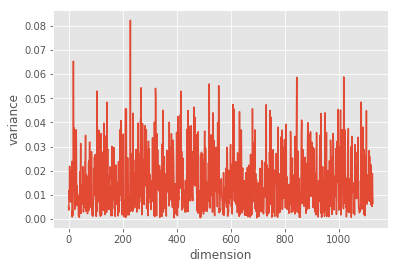

In [29]:
plt.xlabel("dimension")
plt.ylabel("variance")
plt.plot(np.var(matrix, axis=1))

Plot the eigenvalues of the M × M covariance matrix.

In [42]:
# center the variables
# normalize the data
matrixCov = np.cov(matrix - np.mean(matrix, axis=1).reshape(matrix.shape[0],1))

In [41]:
# calculate eigenvalues and eigenvectors
vals, vecs = np.linalg.eigh(matrixCov)

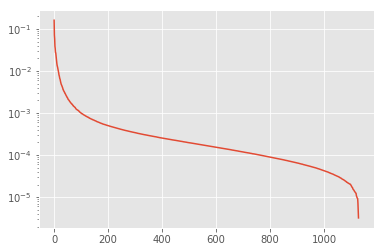

In [43]:
# plot eigenvalues of covariance matrix
vl = vals.tolist()
vl.reverse()
vl /= vals.sum()
plt.semilogy(vl)

Explain the implications for dimensionality reduction:<br>
>Dimensionality reduction aims at explaining data by looking only at parts of it. To accurately classify the data, we need to look at the relations that give us the most information. In this case, the importance of relations is given in the eigenvalues of the covariance matrix. 

How many principal directions do you need to capture 2/3 of the variability in
the data?

In [33]:
vc = np.cumsum(vl)
print('Principal components to capture 2/3:', len(vc[vc < 2/3])+1)

Principal components to capture 2/3: 37


## 3.2 Concept Space

For the five first principal directions, find the 10 tags that have the highest and lowest
coordinates in that direction.

In [34]:
top_eigvecs = vecs[::-1][:5]

In [35]:
k = 1
for vec in top_eigvecs:
    print('Eigenvector', k)
    ix = np.argsort(vec)
    #print(vec[ix[-1]], vec[ix[0]])
    print('Top tags')
    for i in ix[:-11:-1]:
        print(tags_local[i+1]['tag'], end=', ')
    print('\nLow tags')
    for i in ix[:10]:
        print(tags_local[i+1]['tag'], end=', ')
    print('\n')
    k += 1

Eigenvector 1
Top tags
atheism, based on a play, bad, awesome soundtrack, propaganda, san francisco, best of 2005, caper, beautiful, author:neil gaiman, 
Low tags
art house, bad ending, atmospheric, bad acting, suspense, arnold, artificial intelligence, snakes, business, spaghetti western, 

Eigenvector 2
Top tags
art house, bad ending, atmospheric, bad acting, author:alan moore, arnold, assassins, argentina, artificial intelligence, boring!, 
Low tags
atheism, bad, based on a play, awesome soundtrack, author:neil gaiman, beautiful, australia, circus, best of 2005, based on a book, 

Eigenvector 3
Top tags
bad ending, bad acting, bad science, australian, atmospheric, awesome soundtrack, awesome, author:alan moore, wedding, artistic, 
Low tags
assassination, astronauts, bad cgi, bad script, autism, ballet, based on a video game, assassins, wilderness, based on comic, 

Eigenvector 4
Top tags
confrontational, coming-of-age, cuba, doctors, con artists, cute!, dance, confusing, dinosaurs, 

What concepts would you use to describe these dimensions?

1. Concept: Controversiality  
movies which contain controversial topics together with film music and nice scenes (opposite here would be [low tags]: bad acting or endings, ugly things like snakes or Arnold ^^)

2. Concept: abstract as it crosses across genre lines (contains elements of action movie, but also comic animations)
Perhaps the relation between sentimental - action

3. Concept: Comedy / Blockbuster: atmosphere, assasins, coorupt country 

4. Concept: Romantic movie, family movie (doctors, dance or dinosaurs)

5. Concept: dystopia movie (with lots of animations)

Create a Python dict which maps every tag (name) to its coordinates in the 5 first principal
directions and save it to disk.

In [36]:
dictionary = {}
for i in range(len(top_eigvecs[0])):
    dirs = []
    for vec in top_eigvecs:
        dirs.append(vec[i])
    dictionary[tags_local[i]['tag']] = dirs

In [37]:
pickle.dump(dictionary, open('tagsPCA.pickle', 'wb'))

## 3.3 Movie visualization

In [38]:
with open('selected-movies.pickle', 'rb') as file:
    selected_movies = pickle.load(file, encoding='utf-8')

In [65]:
d = dict(x=[], y=[], name=[], score=[], color=[])

for movie in selected_movies:
    coords = matrix.T[movie_index[movie[0]]] @ top_eigvecs[:2,:].T
    d['x'].append(coords[0])
    d['y'].append(coords[1])
    d['name'].append(movie[1])
    d['score'].append(movie[2])
    d['color'].append(rgb2hex(plt.get_cmap('RdYlGn')(movie[2])[:3]))
    
src = ColumnDataSource(d)
hover = HoverTool(
        tooltips=[
            ("name", "@name"),
            ("tomato score","@score"),
        ]
    )

p = figure(tools=[hover], title="Movies scores",x_axis_label='controversiality',y_axis_label='action - sentimental')

p.circle('x', 'y', size=20, source=src, color='color')
output_file("dimred.html")
show(p)

In [66]:
import IPython
IPython.display.HTML(filename="dimred.html")

At first we were thinking no, our 1st principal direction cannot be controversiality:
What could be more controversial than Schindler's list?

Turn out quite some movies:
Ichi the Killer (2011)  
https://en.m.wikipedia.org/wiki/Ichi_the_Killer_(film)
> The film is notorious amongst moviegoers, has raised widespread controversy, and is banned outright in several countries due to its high-impact violence and graphic depictions of cruelty.

But also King's speech similar rating on x-axis:
I was not aware that the rating policy from several motion picture association has sparked widespread controversy and the film was almost cut to remove certain profanities.
https://en.m.wikipedia.org/wiki/The_King%27s_Speech#Ratings_controversy

As for the y-axis:
action - sentimental is a bit more complex as a movie that is both action-packed and sentimental may be mapped to the center (Ichi the Killer), although this is rather infrequent. However a movie which is neither sentimental, nor contains action (aka bad) would also be there.

Schindler's list is a very controversial movie (0.14, 0.15) but also highly sentimental which is confirmed in it's coordinates.

How do the PCA directions correlate with the Rotten Tomatoes score?
>As for the interpretation of the PCA direction correlation, we can observe that movies on any of the 2 PCs extremes tend to perform well.
This is equivalent to saying that the movies in the center are of rather low Tomato score which however grows in concentric circles moving outwards.